In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
import warnings
warnings.filterwarnings('ignore')

### Load the Data* and Make Transformations

In [4]:
Pharma_Sales= pd.read_csv("../data/train.csv")
scaler = MinMaxScaler()
df= pd.DataFrame(Pharma_Sales[['Sales','Date']])

df.head()

,Sales,Date
0,5263,2015-07-31
1,6064,2015-07-31
2,8314,2015-07-31
3,13995,2015-07-31
4,4822,2015-07-31


In [5]:
scaler.fit(df.Sales.values.reshape([-1, 1]))
Pharma_Sales_Scaled= scaler.transform(df.Sales.values.reshape([-1, 1]))
df['Pharma_Sales_Scaled'] = Pharma_Sales_Scaled
df.head()

,Sales,Date,Pharma_Sales_Scaled
0,5263,2015-07-31,0.126664
1,6064,2015-07-31,0.145941
2,8314,2015-07-31,0.200091
3,13995,2015-07-31,0.336815
4,4822,2015-07-31,0.116050


### Descriptive Statistics and Visualizations of the Data.

In [6]:
df.describe()

,Sales,Pharma_Sales_Scaled
count,1.017209e+06,1.017209e+06
mean,5.773819e+03,1.389574e-01
std,3.849926e+03,9.265544e-02
min,0.000000e+00,0.000000e+00
25%,3.727000e+03,8.969700e-02
50%,5.744000e+03,1.382398e-01
75%,7.856000e+03,1.890689e-01
max,4.155100e+04,1.000000e+00


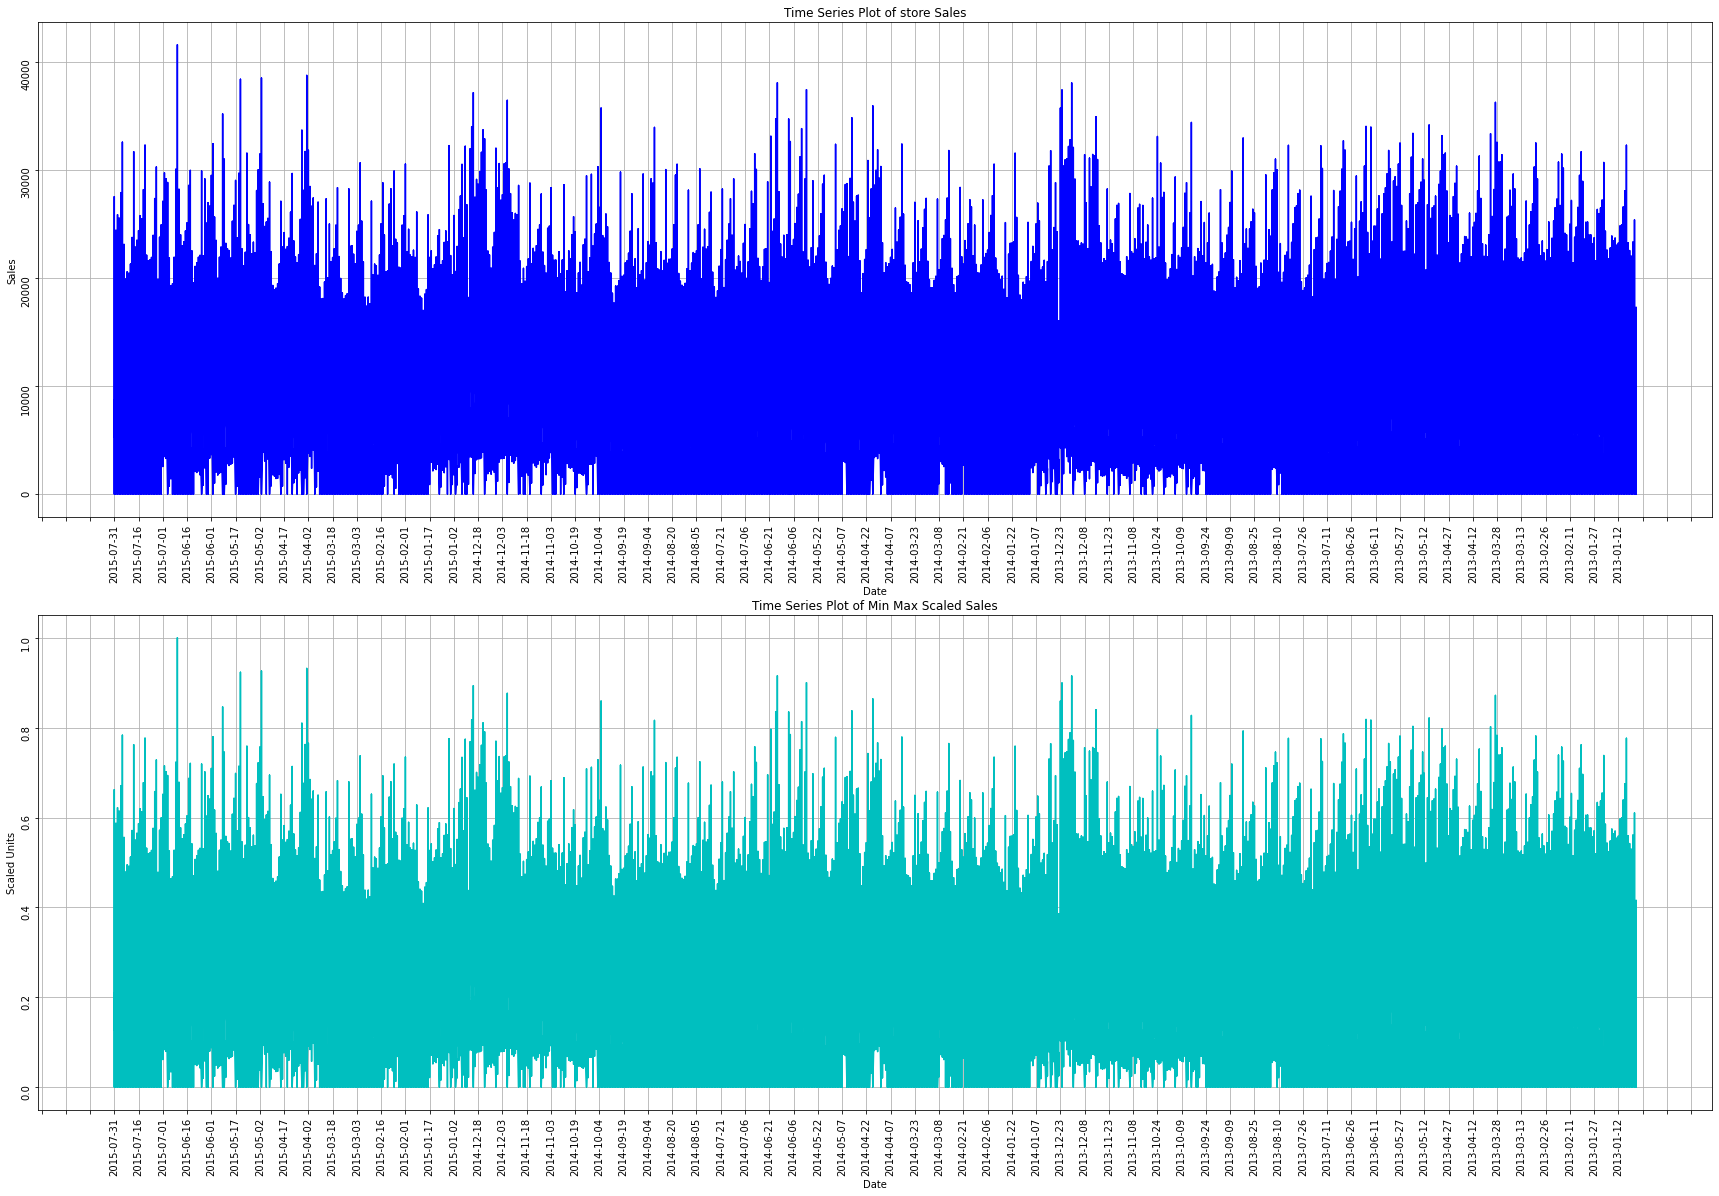

In [7]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(df.Date, df.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales')
ax1.title.set_text('Time Series Plot of store Sales')
ax1.grid(True)
ax2 = fig.add_subplot(gs[1,0])
ax2.plot(df.Date, df.Pharma_Sales_Scaled, 'c-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled Sales')
ax2.grid(True)
plt.show()


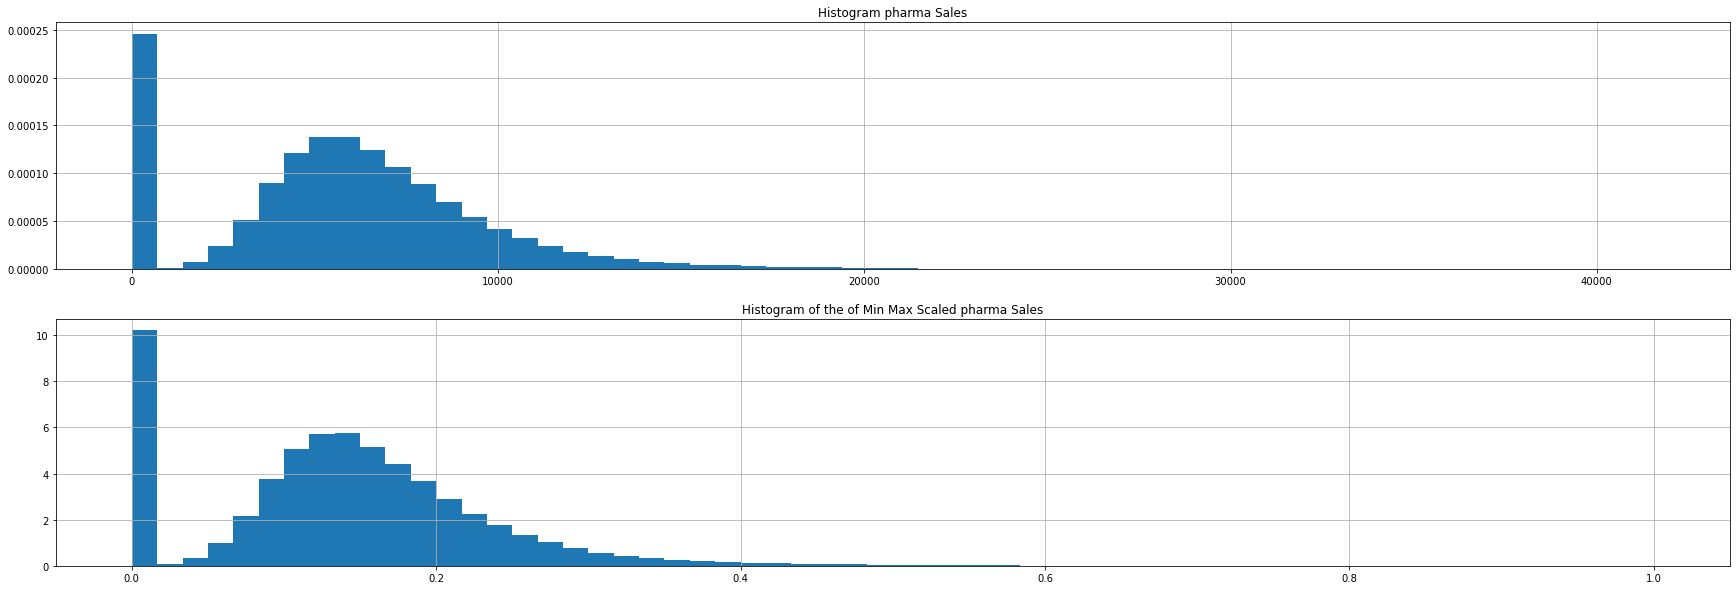

In [8]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(df.Sales, density=True, bins=60)
ax1.title.set_text('Histogram pharma Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(df.Pharma_Sales_Scaled, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled pharma Sales')
ax2.grid(True)
plt.show()

### Unit Root Tests.
Unit Root Tests helps us determine the stationarity of our data



In [ ]:
adfResult = adfuller(df.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

In [ ]:
adfResult = adfuller(df.Pharma_Sales_Scaled.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

### Autocorrelations and Partial Autocorrelations Plots.

We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

In [9]:
acfSalesScaled = acf(df.Pharma_Sales_Scaled.values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)

In [10]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

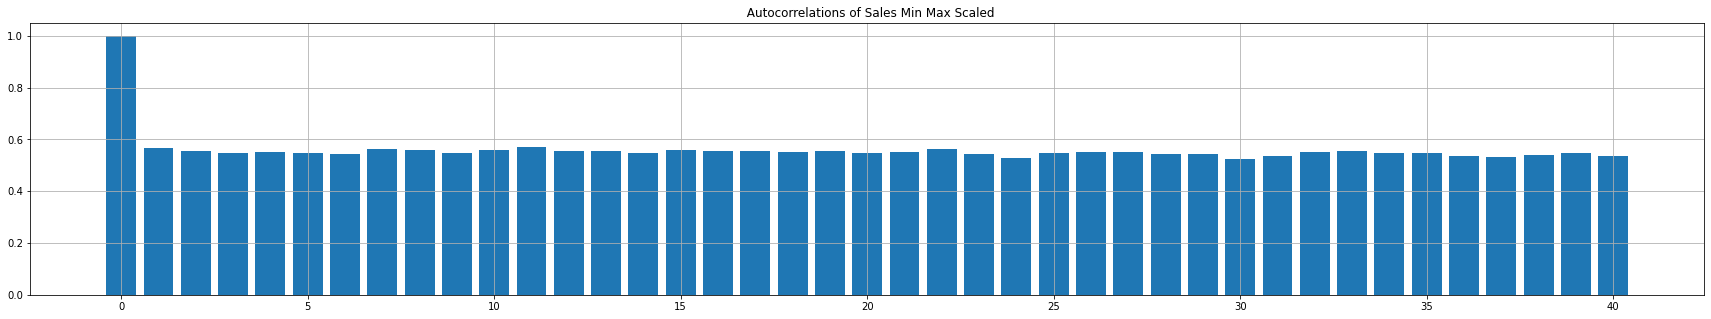

In [11]:
corrPlots(acfSalesScaledNp, '')

In [12]:
pacfSalesScaled = pacf(df.Pharma_Sales_Scaled.values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)

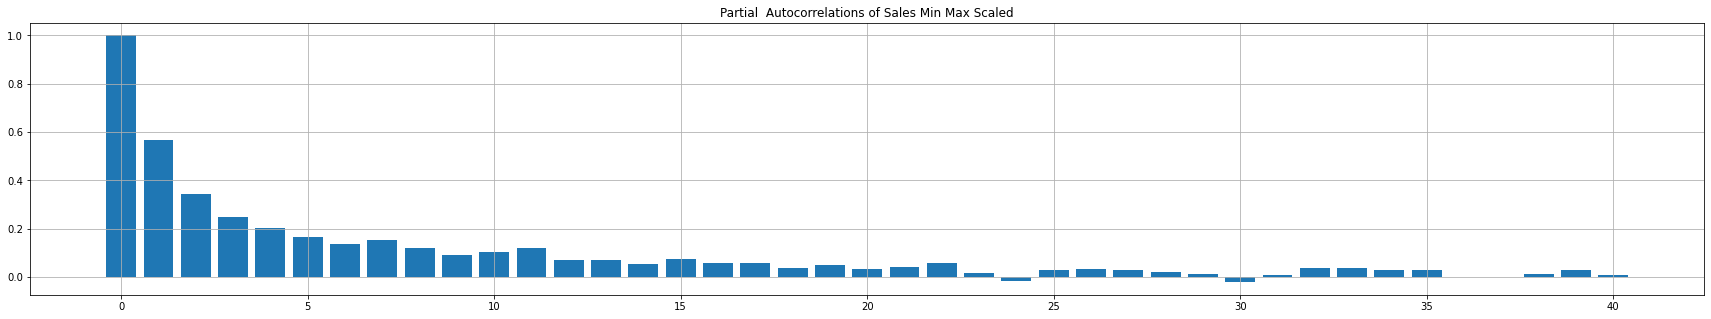

In [13]:
corrPlots(pacfSalesScaledNp, "Partial")

### Separating into a Training and Validation Set Fomat to Use Feed into LSTM.

In [14]:
SIZE = len(df.Pharma_Sales_Scaled)
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 20

In [17]:
DateTrain = df.index.values[0:BATCH_SIZE]
DateValid = df.index.values[BATCH_SIZE:]
XTrain = df.Pharma_Sales_Scaled.values[0:BATCH_SIZE].astype('float32')
XValid = df.Pharma_Sales_Scaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (32, 1)
Shape of the validation set date series:  (1017177, 1)

Shape of the training set logarithm of sales series:  (32,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (1017177,)
